In [1]:
from underlying import Underlying
from option import Option
from trader import Trader

import matplotlib.pyplot as plt
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
def payoff_call(X, K):
    return np.maximum(X.iloc[:,-1]- K, 0)
def payoff_put(X, K):
    return np.maximum(K - X.iloc[:,-1], 0)

In [194]:
mu = 0.06
sigma =  0.3
r = 0.05
T = 1
X0 = 100
repeat = 100

## Full hedging - Vanilla Call

In [195]:
K = 80

In [196]:
underlying = Underlying(mu, sigma, r, 250)

In [197]:
_, reality = underlying.simulate_P(repeat, T)

In [198]:
option = Option(underlying, lambda X: payoff_call(X, K), T)
BS_Price = option.get_MC_price(X0, 0)

In [199]:
W, X = underlying.simulate_P(repeat,option.T)

In [218]:
data = pd.concat([W.iloc[:,-1],X.iloc[:,-1]], axis = 1)
data.columns = ['W','X']

In [219]:
data

,W,X
0,-0.397467,0.901009
1,0.851432,1.310527
2,0.591844,1.212341
3,0.430732,1.155138
4,-0.619832,0.842864
...,...,...
95,0.245737,1.092776
96,-0.317941,0.922764
97,-0.931317,0.767670
98,-0.646228,0.836216


In [221]:
data['dP/dQ*'] = (np.exp(
    (option.underlying.mu - option.underlying.r) * data['W'] / option.underlying.sigma +
    (0.5 * ((option.underlying.mu - option.underlying.r) / option.underlying.sigma) ** 2 +
     option.underlying.r) * option.T) * BS_Price / option.payoff_func(X * X0))
data = data.sort_values('dP/dQ*', ascending = False)

In [222]:
data

,W,X,dP/dQ*
50,-1.258994,0.695796,inf
11,-1.419253,0.663135,inf
35,-0.826302,0.792240,inf
45,-1.045324,0.741858,inf
49,-2.603733,0.464813,inf
...,...,...,...
93,2.239192,1.987262,0.252533
26,2.239586,1.987496,0.252486
8,2.392246,2.080637,0.235318
28,2.471775,2.130874,0.227036


In [223]:
data['dQ*/dP'] = 1/data['dP/dQ*']

In [224]:
data

,W,X,dP/dQ*,dQ*/dP
50,-1.258994,0.695796,inf,0.000000
11,-1.419253,0.663135,inf,0.000000
35,-0.826302,0.792240,inf,0.000000
45,-1.045324,0.741858,inf,0.000000
49,-2.603733,0.464813,inf,0.000000
...,...,...,...,...
93,2.239192,1.987262,0.252533,3.959878
26,2.239586,1.987496,0.252486,3.960608
8,2.392246,2.080637,0.235318,4.249575
28,2.471775,2.130874,0.227036,4.404588


In [273]:
hedge_prob = 0.3

In [274]:
boundary_index = ((data['dQ*/dP'].cumsum()/repeat) < hedge_prob).sum() - 1

In [275]:
boundary_index

63

In [276]:
data['dQ*/dP'].iloc[:boundary_index + 1].sum()/repeat

0.2997785970886454

In [277]:
phi = (hedge_prob - data['dQ*/dP'].iloc[:boundary_index + 1].sum()/repeat) / (data['dQ*/dP'].iloc[boundary_index + 1]/repeat)

In [278]:
phi

0.017598309068554495

In [279]:
data

,W,X,dP/dQ*,dQ*/dP,phi
50,-1.258994,0.695796,inf,0.000000,0.000000
11,-1.419253,0.663135,inf,0.000000,0.000000
35,-0.826302,0.792240,inf,0.000000,0.000000
45,-1.045324,0.741858,inf,0.000000,0.000000
49,-2.603733,0.464813,inf,0.000000,0.000000
...,...,...,...,...,...
93,2.239192,1.987262,0.252533,3.959878,0.000697
26,2.239586,1.987496,0.252486,3.960608,0.000697
8,2.392246,2.080637,0.235318,4.249575,0.000748
28,2.471775,2.130874,0.227036,4.404588,0.000775


In [280]:
k = data['dP/dQ*'].iloc[boundary_index + 1]

In [281]:
k

0.7948544561083113

In [282]:
data['phi'] = ((data['dP/dQ*'] > k)*1 + (data['dP/dQ*'] == k)*phi) * 1/repeat * data['dQ*/dP']

In [283]:
data['phi'].sum()

0.30000000000000004

In [284]:
new_payoff = np.maximum(X0*data['X'] - K,0)* ((data['dP/dQ*'] > k)*1 + 0*(data['dP/dQ*'] == k)*phi)

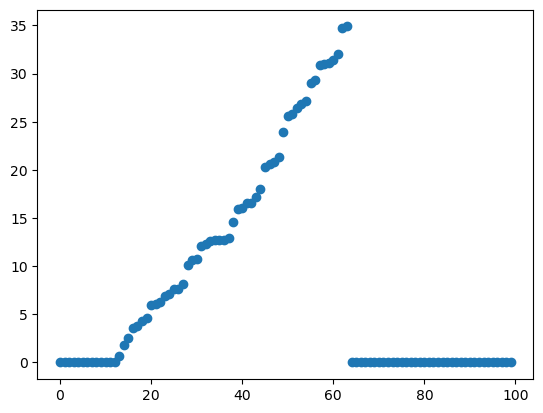

In [285]:
plt.scatter(range(good_sims.shape[0]),new_payoff)

In [286]:
new_payoff = np.maximum(X0*data['X'] - K,0)* ((data['dP/dQ*'] > k)*1 + (data['dP/dQ*'] == k)*phi)

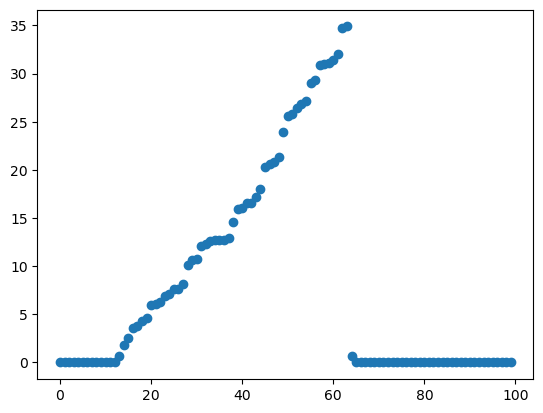

In [287]:
plt.scatter(range(good_sims.shape[0]),new_payoff)